<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# C1: Model Training

This notebook loads the available datasets, splits the datasets into three subsets for training, test and validation, fits the scalers and encoders for feater extraction, extracts the features for all subsets, and trains the prediction model. Finally, selected prediction results for two customers are plotted. 

---

<span style="color:gray">
Version 0.4.5 (October 6, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Dense, LeakyReLU, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import TimeDistributed, Input, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.models import load_model
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from datetime import datetime

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [2]:
path = '..'
timezone = 'Europe/Madrid'
seed = 12345
epsilon = 1e-5
quantiles = [0.5, 0.15865, 0.84135]
epochs = 20
batch_size = 32
learning_rate = 0.00005

In [3]:
properties = {
    'data_path' : path + '/data',
    'models_path' : path + '/models/C1_01',
    't_consumption_daily': [-14, -1],
    't_consumption_hourly': [-7, -1],
    't_weather_daily': [-13, 0],
    't_weather_hourly': [-2, 0],
    'epsilon': epsilon
}

### Function Definitions

In [4]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

def time_from_to(date, t, tz=timezone):
    t0_ = pd.Timestamp(date, tz=tz)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date, tz=tz)+pd.Timedelta(days=t[1])+pd.Timedelta(hours=23)
    return slice(t0_, tn_)

def day_from_to(date, t, tz=timezone):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])
    return slice(t0_, tn_)

def softrange(x, x_min=0, x_max=1):
    dx = x_max - x_min
    return x_min + tf.constant(dx)/tf.math.softplus(dx) * tf.math.softplus(-tf.math.softplus(-x + x_max) + dx)

### Class Definitions for Loading the Data, Extracting the Features, and Training the Prediction Model

#### Data Loader

In [5]:
class DataLoader:
    
    def __init__(self, data_path, model_path):
        self.data_path = data_path
        self.model_path = model_path
        self.categories = ['consumption', 'weather', 'profiles']
        self.files = [self.data_path + '/' + '20201015_' + name + '.xlsx' for name in self.categories]
        return
    
    def scale_data(self, data):
        x = data.groupby(data.index.date).sum()
        x.index = pd.to_datetime(x.index)
        x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index+pd.Timedelta(days=1)))
        x = x.resample('h').ffill()[:-1]
        x.index = data.index
        y = data / x
        return y
    
    def load_metadata(self):
        customers = pd.read_excel(self.files[self.categories.index('profiles')])
        customers.columns = ['customer', 'profile']
        profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])
        holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
        return customers, profiles, holidays
    
    def load_data(self):
        consumptions = pd.read_excel(self.files[self.categories.index('consumption')], parse_dates=[0], index_col=0)
        consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
        consumptions.index.name = 'time'
        consumptions = fix_DST(consumptions)
        crop(consumptions)
        consumptions_scaled = self.scale_data(consumptions)
        weather = pd.read_excel(self.files[self.categories.index('weather')], parse_dates=[0], index_col=0)
        weather.columns = consumptions.columns
        weather.index.name = 'time'
        weather = fix_DST(weather)
        weather_forecast = weather.copy()
        weather_forecast.index = weather.index-pd.Timedelta(days=1)
        crop(weather)
        crop(weather_forecast)
        return consumptions, consumptions_scaled, weather, weather_forecast

#### Feature Extractor

In [6]:
class FeatureExtractor:
    
    def __init__(self, properties, customers, consumptions, weather, weather_forecast, holidays):
        self.model_path = properties.get('model_path', '/tmp')
        self.t_consumption_daily = properties.get('t_consumption_daily', [-13, -1])
        self.t_consumption_hourly = properties.get('t_consumption_hourly', [-2, -1])
        self.t_weather_daily = properties.get('t_weather_daily', [-2, -0])
        self.t_weather_hourly = properties.get('t_weather_hourly', [-2, -0])
        self.encoder = properties.get('encoder')
        self.epsilon = properties.get('epsilon', 1e-5)
        self.scaler_names = ['consumptions', 'consumptions_daily_mean',
                             'weather_daily_mean', 'day_of_month', 'month',
                             'weather_forecast']
        self.scalers = properties.get('scalers', {})
        self.customers = customers
        self.consumptions = consumptions
        self.weather = weather
        self.weather_forecast = weather_forecast
        self.holidays = holidays
        self.days = self.get_days(consumptions.index, holidays)
        self.consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), 
                                               index=self.days.index)
        self.weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), 
                                               index=self.days.index)
        return

    def get_days(self, dates, holidays):
        days = pd.DataFrame(pd.to_datetime(dates.date), index=dates, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        return days
        
    def split(self, indices, seed=12345):
        n = len(indices)
        n_validate = n//10
        n_test = n//10
        n_train = n-n_validate - n_test
        np.random.seed(seed)
        I = np.random.permutation(indices)
        I_train = I[0:n_train]
        I_test = I[n_train:n_train + n_test]
        I_validate = I[n_train + n_test:]
        return I_train, I_test, I_validate

    def fit(self):
        I_train, I_test, I_validate = self.split(self.customers, seed)
        self.scalers['consumptions'] = RobustScaler(quantile_range=(0,75))
        self.scalers['consumptions'].fit(self.consumptions_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['weather'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather'].fit(self.weather_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['day_of_month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['day_of_month'].fit(self.days['day_of_month'].values.reshape(-1, 1))
        self.scalers['month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['month'].fit(self.days['month'].values.reshape(-1, 1))
        X = self.weather_forecast.loc[:, I_train]
        X.index = pd.MultiIndex.from_arrays([X.index.date, X.index.time], names=['date','time'])
        X = X.stack().unstack(level=1)
        self.scalers['weather_forecast'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather_forecast'].fit(X)
        dates = self.consumptions_daily_mean.index.date
        return [I_train, I_test, I_validate], dates, self.scalers
    
    def load(self):
        scalers = [joblib.load(self.model_path + '/' + name) for name in self.scaler_names]
        self.scalers = dict(zip(self.scaler_names, scalers))
        return
    
    def extract(self, date, customer):
        epsilon = self.epsilon
        X1 = self.consumptions.loc[time_from_to(date, self.t_consumption_hourly),customer].values
        X1 = np.array(X1).reshape(-1) + epsilon
        X2 = self.weather.loc[time_from_to(date, self.t_weather_hourly),customer].values
        X2 = self.scalers['weather_forecast'].transform(np.array(X2).reshape(3,24)).reshape(-1)
        X2 = (X2+1)/2
        X3 = self.days.loc[pd.Timestamp(date),'day_of_month']
        X3 = self.scalers['day_of_month'].transform(np.array([X3]).reshape(-1,1))[0][0]
        X3 = (X3+1)/2
        X4 = self.days.loc[pd.Timestamp(date),'month']
        X4 = self.scalers['month'].transform(np.array([X4]).reshape(-1,1))[0][0]
        X4 = (X4+1)/2
        X5 = self.days.loc[pd.Timestamp(date),'day_category']
        X5 = self.encoder.transform(np.array(X5).reshape(1, -1)).reshape(-1)
        X6 = self.consumptions_daily_mean.loc[day_from_to(date, self.t_consumption_daily), customer].values
        X6 = X6/(2*self.scalers['consumptions'].scale_) + epsilon
        X7 = self.weather_daily_mean.loc[day_from_to(date, self.t_weather_daily), customer].values
        X7 = self.scalers['weather'].transform(np.array([X7]).reshape(-1,1)).reshape(-1)
        X7 = (X7+1)/2
        Xa = np.concatenate([X1, X2, [X3], [X4], X5]).reshape(1,-1)
        ya = self.consumptions.loc[time_from_to(date, [0, 0]),customer].values + epsilon
        Xb = np.concatenate([X6, X7, [X3], [X4], X5]).reshape(1,-1)
        yb = self.consumptions_daily_mean.loc[day_from_to(date, [0, 0]), customer].values + epsilon
        return [Xa, ya, Xb, yb]

#### Loss Function Negative Log-Likelihood

In [7]:
f_loss = lambda y, p_y: -p_y.log_prob(y)

#### AleatoricResidual Layer

In [8]:
class AleatoricResidual(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(AleatoricResidual, self).__init__(**kwargs)

    def call(self, input):
        mean_val = input[1][:,:1]
        std_val = input[1][:,1:]
        predicted_mean_delta = input[0][:,:1]
        predicted_std_delta = input[0][:,1:]
            
        predicted_mean = mean_val + predicted_mean_delta
        predicted_std = softrange(std_val + predicted_std_delta, x_max=3.0)
        return tf.concat([predicted_mean, predicted_std], axis=1)

    def get_config(self):
        return {}

#### ExponentialMeanAndDeviation Layer

In [9]:
class ExponentialMeanAndDeviation(tf.keras.layers.Layer):

    def __init__(self, n_days_back, **kwargs):
        super(ExponentialMeanAndDeviation, self).__init__(**kwargs)
        self.n_days_back = n_days_back
        self.epsilon = 1e-5
        return
    
    def build(self, input_shape):
        self.lambda_mean = tf.Variable(name="lambda_mean", initial_value=0.5, trainable=True)
        self.lambda_std = tf.Variable(name="lambda_std", initial_value=0.5, trainable=True)
        return
    
    def call(self, input):
        r = tf.range(self.n_days_back, 0, delta=-1, dtype=tf.float32) - 1
        x_mean = tf.expand_dims(tf.math.exp(-tf.math.softplus(self.lambda_mean) * r), 0)
        x_std = tf.expand_dims(tf.math.exp(-tf.math.softplus(self.lambda_std) * r), 0)
        X_mean = tf.reduce_sum(x_mean)
        X_std = tf.reduce_sum(x_std)
        
        mean = tf.math.reduce_sum(tf.math.log(input[:,:self.n_days_back])*x_mean, 
                                  axis=1, keepdims=True)/X_mean
        std = tf.math.sqrt(tf.math.reduce_sum(((tf.math.log(input[:,:self.n_days_back])-mean)**2)*x_std, 
                                  axis=1, keepdims=True)/(X_std*(1-1/self.n_days_back))+self.epsilon)
        return tf.concat([mean, std], axis=1)
    
    def get_config(self):
        return {"n_days_back": self.n_days_back}

#### ScalingBySampling Layer

In [10]:
class ScalingBySampling(tf.keras.layers.Layer):

    def __init__(self, n_samples = 100, lower_q=15.865, upper_q=84.135, offset=1e-5, **kwargs):
        self.n_samples = n_samples
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.epsilon = 1e-5
        super(ScalingBySampling, self).__init__(**kwargs)

    def call(self, input):
        # gaussian error propagation
        epsilon = self.epsilon
        x = input[0]
        x_center = tf.math.maximum(x.quantile(0.5),0)
        x_mean = tf.math.maximum(x.mean(),0)
        X = input[1]
        X_center = tf.math.maximum(X.quantile(0.5), 0.)
        X_mean = tf.math.maximum(X.mean(),0)
        
        samples = x.sample(self.n_samples)
        samples = tf.math.reduce_sum(samples, axis=2)
        x_sum_center = tf.expand_dims(tfp.stats.percentile(samples, 50., axis=0), axis=1)
        x_sum_mean = tf.expand_dims(tf.math.reduce_mean(samples, axis=0),axis=1)
        x_center = (x_center + epsilon) * (X_center + epsilon) / (x_sum_center + 24 * epsilon)
        x_mu = tf.math.log(x_center)
        x_mean = (x_mean + epsilon) * (X_mean + epsilon) / (x_sum_mean + 24 * epsilon)
        x_sigma = tf.math.sqrt(tf.math.maximum(2 * (tf.math.log(x_mean) - x_mu),0))
        x_upper = tf.math.exp(x_mu) * tf.math.exp(x_sigma)
        x_lower = tf.math.exp(x_mu) / tf.math.exp(x_sigma)
        
        # set very tiny values to zero to enable correct calculation 
        # of percentage inside confidence interval
        I = tf.cast(x_lower<epsilon, tf.float32)
        x_lower = tf.zeros_like(x_lower) * I + x_lower * (1 - I)
        return tf.concat([x_center, x_lower, x_upper], axis=1)

#### Prediction Model

In [11]:
class PredictionModel:
    
    def __init__(self, properties):
        self.path = properties.get('models_path', '/tmp')
        self.epochs_a = properties.get('epochs_a', 40)
        self.epochs_b = properties.get('epochs_b', 100)
        self.batch_size_a = properties.get('batch_size_a', 32)
        self.batch_size_b = properties.get('batch_size_b', 144)
        self.epsilon = properties.get('epsilon', 1e-5)
        self.filters = properties.get('conv_filters', 32)
        self.padding = properties.get('padding', 'same')
        self.kernel = properties.get('conv_kernel', (5,))
        self.pool = properties.get('pool_size', 3)
        self.units = properties.get('dense_units', 200)
        self.strides = properties.get('strides', 2)
        self.activation = properties.get('activation', 'linear')
        self.alpha = properties.get('relu_alpha', 0.05)
        self.dropout_a = properties.get('dropout_a', 0.0)
        self.dropout_b = properties.get('dropout_b', 0.0)
        self.scalers = properties.get('scalers')
        self.inputs = properties.get('inputs', [247, 35])
        self.outputs = properties.get('outputs', [24, 1])
        self.scale = self.scalers['consumptions'].scale_
        self.offset = self.scalers['consumptions'].center_
        return
    
    def get_samples(self, Xy):
        Xa = np.concatenate([Xy[i][0] for i in range(len(Xy))])
        ya = np.concatenate([Xy[i][1] for i in range(len(Xy))]).reshape(-1,24)
        Xb = np.concatenate([Xy[i][2] for i in range(len(Xy))])
        yb = np.concatenate([Xy[i][3] for i in range(len(Xy))]).reshape(-1,1)
        return Xa, ya, Xb, yb

    def create(self):
        Xa_in = Input((self.inputs[0],), name='A00')
        xa_reshape = Reshape((self.inputs[0],1), name='A01')(Xa_in)
        
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A02')(xa_reshape[:,:240,:])
        xa = LeakyReLU(alpha=self.alpha, name='A03')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A04')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A05')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A06')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A07')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A08')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A09')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A10')(xa)
        xa = Flatten(name='A11')(xa)
        
        xa = Concatenate(name='A12')([xa, xa_reshape[:,240:,0]])
        xa = Dense(units = 2*self.outputs[0], activation=self.activation, name='A13')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A14')(xa)
        xa = Reshape((self.outputs[0],2), name='A15')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A16')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A17')(xa)
        xa = Conv1D(filters=2, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A18')(xa)
        xa_params = Flatten(name='A19')(xa)

        Xa_out = tfp.layers.DistributionLambda(lambda t: tfd.LogNormal(loc=t[:, :24],
                            scale=tf.math.softplus(t[:,24:]),
                            validate_args=True), name='A20_Output_Distribution_A')(xa_params)

        Xb_in = Input((self.inputs[1],), name='B00')
        xb_mean = ExponentialMeanAndDeviation(n_days_back = 14, name='B01')(Xb_in)        
        
        xb = Dense(units=self.units, activation=self.activation, name='B02')(Xb_in)
        xb = LeakyReLU(alpha=self.alpha, name='B03')(xb)
        xb = Dropout(self.dropout_b, name='B04')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B05')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B06')(xb)
        xb = Dropout(self.dropout_b, name='B07')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B08')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B09')(xb)
        xb = Dropout(self.dropout_b, name='B10')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B11')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B12')(xb)
        xb = Dense(units=2, activation=self.activation, name='B13')(xb)
        xb_aleatoric = AleatoricResidual(name='B14')([xb, xb_mean])
        Xb_out = tfp.layers.DistributionLambda(
            lambda t: tfd.LogNormal(loc=t[:, :1],scale=t[:,1:], validate_args=True),
            name='B15_Output_Distribution_B')(xb_aleatoric)
        
        self.model_a = Model(inputs=Xa_in, outputs=Xa_out)
        self.model_b = Model(inputs=Xb_in, outputs=Xb_out)
        
        f_distribution_a = lambda t: bijectors.Shift(-self.epsilon)(t)
        f_distribution_b = lambda t: bijectors.Scale(2.0*self.scale.astype('float32'))\
                                    (bijectors.Shift(-self.epsilon)(t))
        
        X_out_b = tfp.layers.DistributionLambda(f_distribution_b, name="C00")(self.model_b.output)
        x = tfp.layers.DistributionLambda(f_distribution_a, name='C01')(self.model_a.output)
        X_out_a = ScalingBySampling(n_samples=5000, name='C02')([x, X_out_b])
        
        self.model = Model(inputs=[self.model_a.input, self.model_b.input], outputs=[X_out_a, X_out_b])
        return
        
        
    def compile(self):
        self.model_a.compile(optimizer = Adam(learning_rate=learning_rate), loss=f_loss)
        self.model_b.compile(optimizer = Adam(learning_rate=learning_rate), loss=f_loss)
        self.model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error')
        self.model.summary()
        return

    def train(self, Xy):
        self.Xa_train, self.ya_train, self.Xb_train, self.yb_train = self.get_samples(Xy[0])
        self.Xa_test, self.ya_test, self.Xb_test, self.yb_test = self.get_samples(Xy[1])
        self.Xa_validate, self.ya_validate, self.Xb_validate, self.yb_validate = self.get_samples(Xy[2])
        
        checkpoint_a = ModelCheckpoint(self.path + '/' + 'model_a.h5', monitor='val_loss', 
                                       verbose=1, save_best_only=True, mode='min')
        checkpoint_b = ModelCheckpoint(self.path + '/' + 'model_b.h5', monitor='val_loss', 
                                       verbose=1, save_best_only=True, mode='min')
        self.model_a.fit(self.Xa_train, self.ya_train, epochs=self.epochs_a, batch_size=self.batch_size_a,
          validation_data=(self.Xa_test, self.ya_test), callbacks=[checkpoint_a])        
        self.model_b.fit(self.Xb_train, self.yb_train, epochs = self.epochs_b, batch_size=self.batch_size_b,
          validation_data=(self.Xb_test, self.yb_test), callbacks=[checkpoint_b])
        
        self.load()
        return
    
    def evaluate(self):
        model_a = self.model_a
        model_b = self.model_b
        score_a_test = model_a.evaluate(model.Xa_test, model.ya_test)
        score_a_validate = model_a.evaluate(model.Xa_validate, model.ya_validate)
        mse_a_test = np.mean((model_a(model.Xa_test).quantile(0.5).numpy() - model.ya_test)**2, axis=(0,1))
        mse_a_validate = np.mean((model_a(model.Xa_validate).quantile(0.5).numpy() - model.ya_validate)**2, 
                                 axis=(0,1))
        score_b_test = model_b.evaluate(model.Xb_test, model.yb_test)
        score_b_validate = model_b.evaluate(model.Xb_validate, model.yb_validate)
        mse_b_test = np.mean((model_b(model.Xb_test).quantile(0.5).numpy() - model.yb_test)**2, axis=(0,1))
        mse_b_validate = np.mean((model_b(model.Xb_validate).quantile(0.5).numpy() - 
                                model.yb_validate)**2, axis=(0,1))
        return
        
    def predict(self, features):
        predictions = [self.model([x[0], x[2]]) for x in features]
        return predictions
        
    def plot(self, predictions, consumptions, dates, selected_dates, selected_customer):
        slices = [slice(0, 24), slice(24, 48), slice(48, None)]
        t_ticks = np.linspace(0,24,5, dtype='int')
        t_labels = ['{:02}:00'.format(h) for h in np.linspace(0,24,5, dtype='int')]
        dates_i = [list(dates).index(datetime.strptime(date, '%Y-%m-%d').date()) for date in selected_dates]
        consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean())
        customers_ = [list(customers['customer'].values).index(selected_customer)]
        
        y_daily = [24*np.array([np.maximum(p[1].quantile(q),0)[0][0] for p in predictions]) for q in quantiles]
        y_intraday = [[24*p[0].numpy()[0,s] for s in slices] for p in predictions]
        y_daily_real = [24*consumptions_daily_mean.iloc[15:,customer].to_numpy() for customer in customers_]
        y_intraday_real = [[consumptions.loc[date,customer] for date in selected_dates] for customer in customers_]
        
        figure = plt.figure(figsize=(20,10))
        ax1 = plt.subplot2grid((2,4), (0,0), title=f"Customer {selected_customer}", colspan=4)
        ax1.plot(dates[15:],y_daily_real[0], alpha=0.7, color='b')
        ax1.plot(dates[15:],y_daily[0], alpha=0.7, color='orange')
        ax1.fill_between(dates[15:], y_daily[1], y_daily[2], alpha=0.2, color='orange')
        for i in range(len(dates_i)):
            title = 'Date ' + selected_dates[i] + ' (' + dates[dates_i[i]].strftime('%A') + ')'
            ax_i=plt.subplot2grid((2,4), (1,i), title=title)
            ax_i.plot(np.arange(24),y_intraday_real[0][i], alpha=0.7, color='b')
            ax_i.plot(np.arange(24),y_intraday[dates_i[i]-15][0], alpha=0.7, color='orange')
            ax_i.fill_between(np.arange(24), y_intraday[dates_i[i]-15][1], y_intraday[dates_i[i]-15][2], 
                              alpha=0.2, color='orange')
            ax_i.set_xticks(t_ticks)
            ax_i.set_xticklabels(t_labels)
            ax_i.set_xlim(0,24)
            #ax_i.set_ylim(0,2)
        plt.show()
        return
    
    def load(self, path=None):
        if path != None:
            self.path = path      
        self.model_a = load_model(self.path + '/' + 'model_a.h5', custom_objects={'<lambda>': f_loss})
        self.model_b = load_model(self.path + '/' + 'model_b.h5', custom_objects={'<lambda>': f_loss, 
                            'AleatoricResidual': AleatoricResidual,
                            'ExponentialMeanAndDeviation': ExponentialMeanAndDeviation})
        
        f_distribution_a = lambda t: bijectors.Shift(-self.epsilon)(t)
        f_distribution_b = lambda t: bijectors.Scale(2.0*self.scale.astype('float32'))\
                                    (bijectors.Shift(-self.epsilon)(t))      
        X_out_b = tfp.layers.DistributionLambda(f_distribution_b, name="C00")(self.model_b.output)
        x = tfp.layers.DistributionLambda(f_distribution_a, name='C01')(self.model_a.output)
        X_out_a = ScalingBySampling(n_samples=5000, name='C02')([x, X_out_b])
        self.model = Model(inputs=[self.model_a.input, self.model_b.input], outputs=[X_out_a, X_out_b])
        self.model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error')    
        return

### Loading Data

In [12]:
loader = DataLoader(path + '/data', path + '/models')
consumptions, consumptions_scaled, weather, weather_forecast = loader.load_data()
customers, profiles, holidays = loader.load_metadata()
encoder = OneHotEncoder(sparse=False)
encoder.fit(np.arange(5).reshape(-1,1))

OneHotEncoder(sparse=False)

In [13]:
properties['encoder'] = encoder

### Extracting Features

In [14]:
selected_customers = customers[customers['profile'].astype(str).str.contains('hogares')].index.values

In [15]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, weather, weather_forecast, holidays)

In [16]:
I, dates, scalers = extractor.fit()

In [17]:
features = [[extractor.extract(date, customer) for date in dates[15:] for customer in Ii] for Ii in I]

### Model Training

In [18]:
properties['scalers'] = scalers

In [19]:
model = PredictionModel(properties)
model.create()
model.compile()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A00 (InputLayer)                [(None, 247)]        0                                            
__________________________________________________________________________________________________
A01 (Reshape)                   (None, 247, 1)       0           A00[0][0]                        
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 240, 1)       0           A01[0][0]                        
__________________________________________________________________________________________________
A02 (Conv1D)                    (None, 240, 32)      192         tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

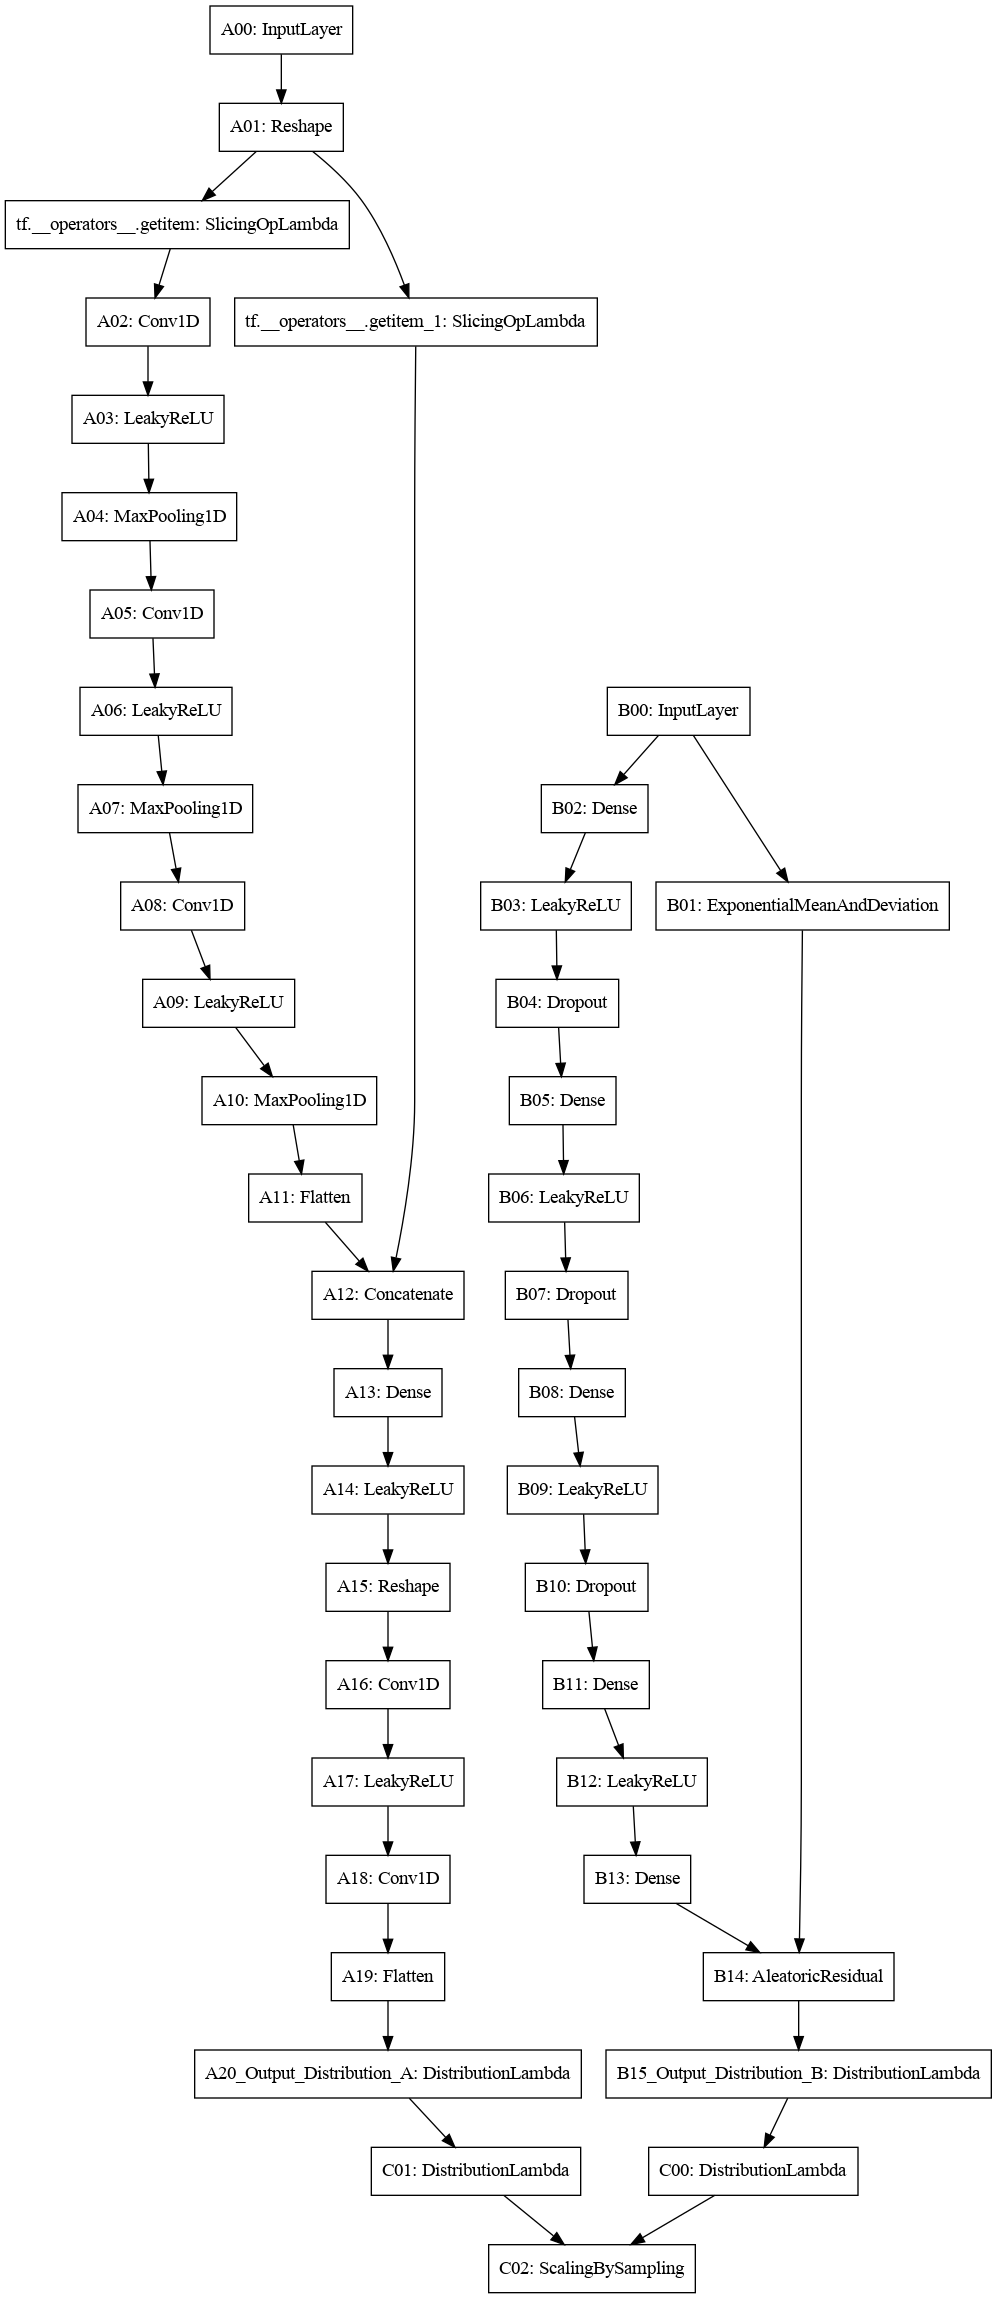

In [20]:
plot_model(model.model)

In [21]:
model.train(features)

Epoch 1/40
2757/2757 [==============================] - 27s 10ms/step - loss: 1.7035 - val_loss: -0.3736

Epoch 00001: val_loss improved from inf to -0.37355, saving model to ../models/C1_01/model_a.h5
Epoch 2/40
2757/2757 [==============================] - 27s 10ms/step - loss: -0.2562 - val_loss: -0.7002

Epoch 00002: val_loss improved from -0.37355 to -0.70025, saving model to ../models/C1_01/model_a.h5
Epoch 3/40
2757/2757 [==============================] - 29s 10ms/step - loss: -0.5698 - val_loss: -0.7609

Epoch 00003: val_loss improved from -0.70025 to -0.76090, saving model to ../models/C1_01/model_a.h5
Epoch 4/40
2757/2757 [==============================] - 29s 11ms/step - loss: -0.6291 - val_loss: -0.8336

Epoch 00004: val_loss improved from -0.76090 to -0.83358, saving model to ../models/C1_01/model_a.h5
Epoch 5/40
2757/2757 [==============================] - 28s 10ms/step - loss: -0.7302 - val_loss: -0.9866

Epoch 00005: val_loss improved from -0.83358 to -0.98665, saving mo

613/613 [==============================] - 2s 3ms/step - loss: -1.4608 - val_loss: -1.1503

Epoch 00005: val_loss improved from -1.14591 to -1.15029, saving model to ../models/C1_01/model_b.h5
Epoch 6/100
613/613 [==============================] - 2s 3ms/step - loss: -1.4687 - val_loss: -1.1390

Epoch 00006: val_loss did not improve from -1.15029
Epoch 7/100
613/613 [==============================] - 2s 3ms/step - loss: -1.4981 - val_loss: -1.2424

Epoch 00007: val_loss improved from -1.15029 to -1.24236, saving model to ../models/C1_01/model_b.h5
Epoch 8/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5188 - val_loss: -1.2220

Epoch 00008: val_loss did not improve from -1.24236
Epoch 9/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5380 - val_loss: -1.2348

Epoch 00009: val_loss did not improve from -1.24236
Epoch 10/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5512 - val_loss: -1.3557

Epoch 00010: val_loss improve

Epoch 55/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7595 - val_loss: -1.3352

Epoch 00055: val_loss did not improve from -1.50077
Epoch 56/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7624 - val_loss: -1.4129

Epoch 00056: val_loss did not improve from -1.50077
Epoch 57/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7686 - val_loss: -1.3489

Epoch 00057: val_loss did not improve from -1.50077
Epoch 58/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7723 - val_loss: -1.4583

Epoch 00058: val_loss did not improve from -1.50077
Epoch 59/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7679 - val_loss: -1.4046

Epoch 00059: val_loss did not improve from -1.50077
Epoch 60/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7635 - val_loss: -1.5285

Epoch 00060: val_loss improved from -1.50077 to -1.52849, saving model to ../models/C1_01/model_b.h5
Epoch 61/

### Plotting Prediction Results

#### Example 1

In [22]:
selected_customer_names = ['5d6fcd7cf44b0324bc6b79dc', '5d6fcd69f44b0324bc6b788a', '5d6fcd1df44b0324bc6b7260']
selected_customers = [list(customers['customer'].values).index(name) for name in selected_customer_names]

In [23]:
selected_customer = selected_customers[0]
selected_dates = ['2019-10-24', '2019-08-22', '2019-01-27', '2019-10-16']

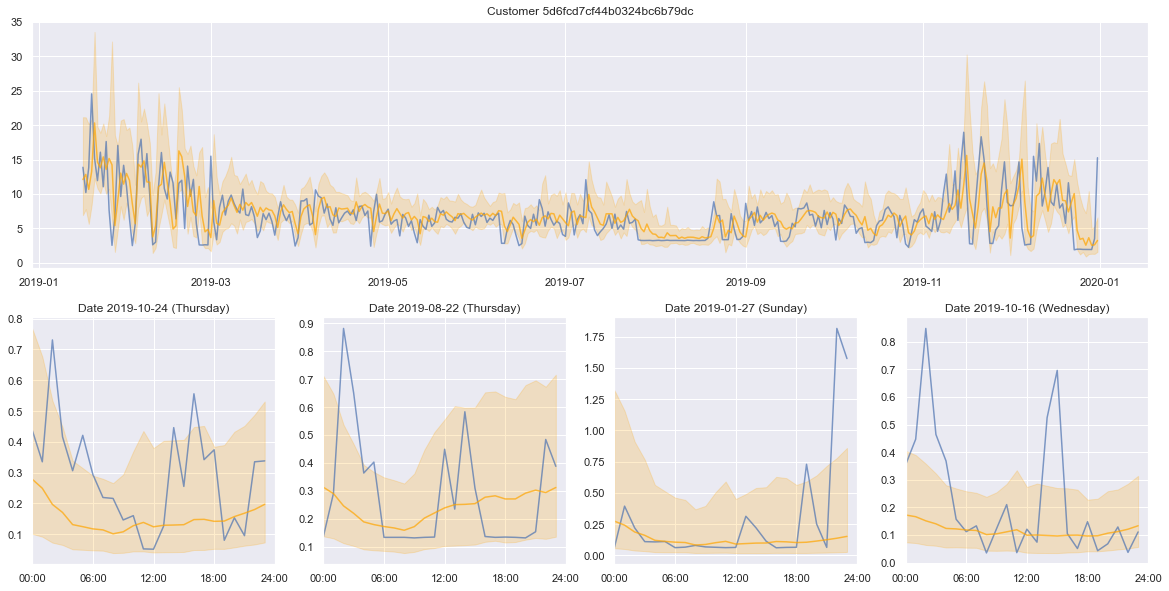

In [24]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, weather, weather_forecast, holidays)
features = [extractor.extract(date, selected_customer) for date in dates[15:]]
model = PredictionModel(properties)
model.load()
predictions = model.predict(features)
model.plot(predictions, consumptions, dates, selected_dates, selected_customer_names[0])

#### Example 2

In [25]:
selected_customer = selected_customers[0]
selected_dates = ['2019-08-08', '2019-11-24', '2019-05-03', '2019-10-30']

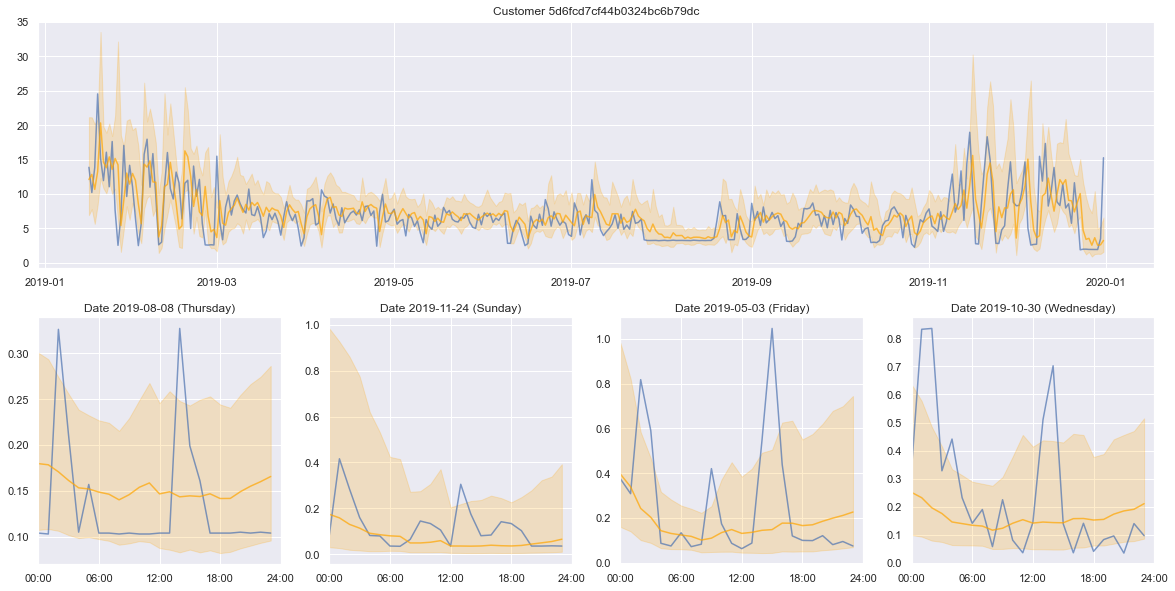

In [26]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, weather, weather_forecast, holidays)
features = [extractor.extract(date, selected_customer) for date in dates[15:]]
model = PredictionModel(properties)
model.load()
predictions = model.predict(features)
model.plot(predictions, consumptions, dates, selected_dates, selected_customer_names[0])

#### Example 3

In [27]:
selected_customer = selected_customers[1]
selected_dates = ['2019-02-18', '2019-12-08', '2019-03-20', '2019-12-19']

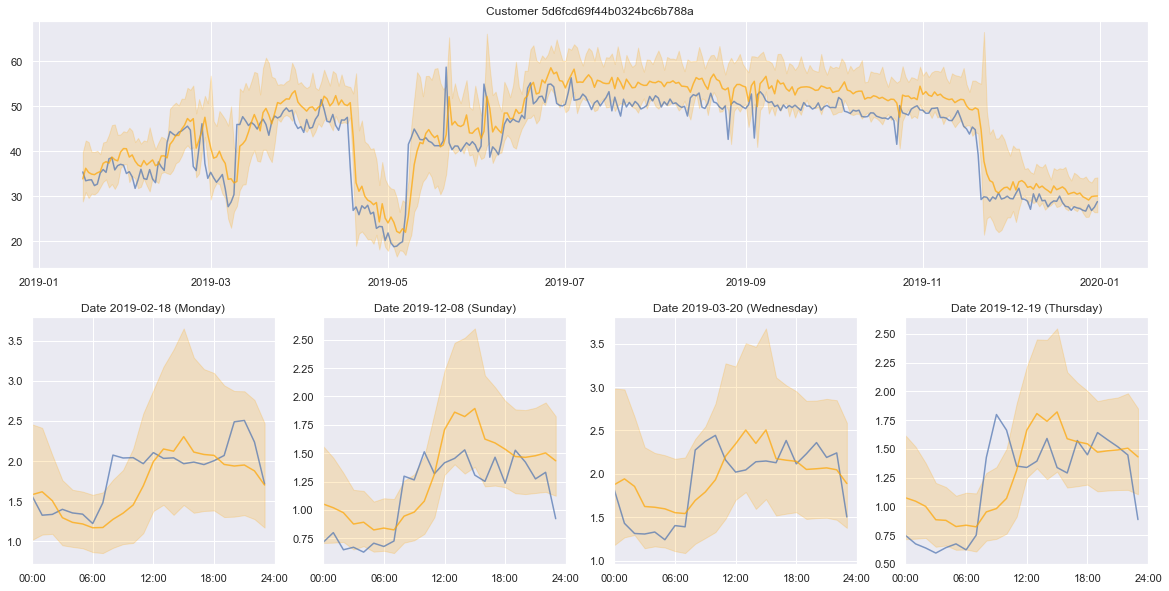

In [28]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, weather, weather_forecast, holidays)
features = [extractor.extract(date, selected_customer) for date in dates[15:]]
model = PredictionModel(properties)
model.load()
predictions = model.predict(features)
model.plot(predictions, consumptions, dates, selected_dates, selected_customer_names[1])

#### Example 4

In [29]:
selected_customer = selected_customers[2]
selected_dates = ['2019-02-18', '2019-12-08', '2019-03-20', '2019-12-19']

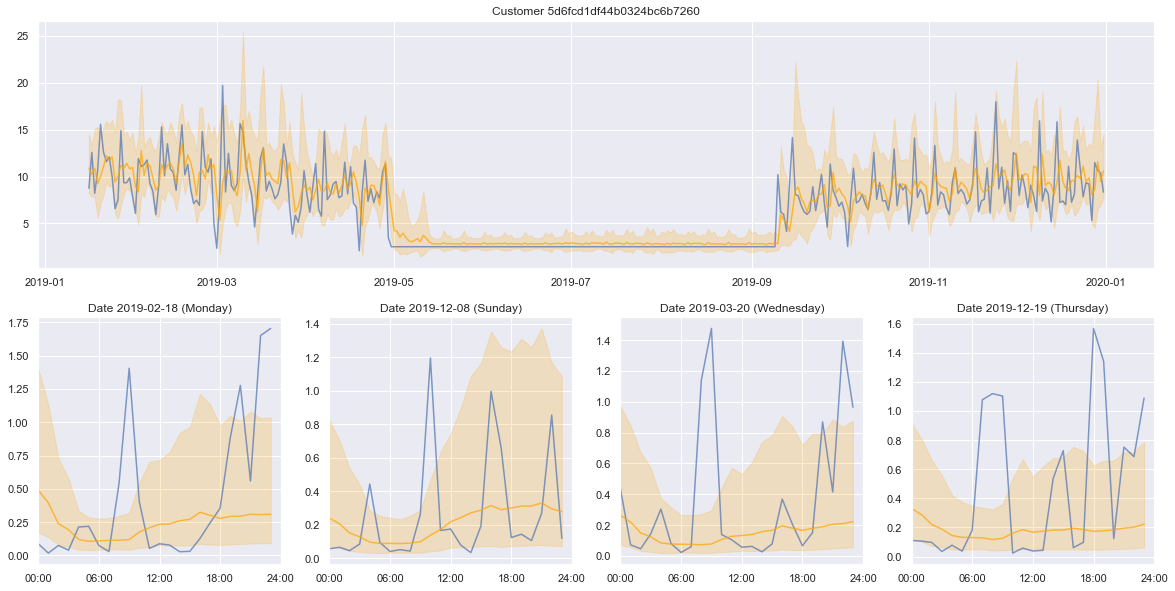

In [30]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, weather, weather_forecast, holidays)
features = [extractor.extract(date, selected_customer) for date in dates[15:]]
model = PredictionModel(properties)
model.load()
predictions = model.predict(features)
model.plot(predictions, consumptions, dates, selected_dates, selected_customer_names[2])